# Trexquant Interview Project (The Hangman Game)

* Copyright Trexquant Investment LP. All Rights Reserved. 
* Redistribution of this question without written consent from Trexquant is prohibited

## Instruction:
For this coding test, your mission is to write an algorithm that plays the game of Hangman through our API server. 

When a user plays Hangman, the server first selects a secret word at random from a list. The server then returns a row of underscores (space separated)—one for each letter in the secret word—and asks the user to guess a letter. If the user guesses a letter that is in the word, the word is redisplayed with all instances of that letter shown in the correct positions, along with any letters correctly guessed on previous turns. If the letter does not appear in the word, the user is charged with an incorrect guess. The user keeps guessing letters until either (1) the user has correctly guessed all the letters in the word
or (2) the user has made six incorrect guesses.

You are required to write a "guess" function that takes current word (with underscores) as input and returns a guess letter. You will use the API codes below to play 1,000 Hangman games. You have the opportunity to practice before you want to start recording your game results.

Your algorithm is permitted to use a training set of approximately 250,000 dictionary words. Your algorithm will be tested on an entirely disjoint set of 250,000 dictionary words. Please note that this means the words that you will ultimately be tested on do NOT appear in the dictionary that you are given. You are not permitted to use any dictionary other than the training dictionary we provided. This requirement will be strictly enforced by code review.

You are provided with a basic, working algorithm. This algorithm will match the provided masked string (e.g. a _ _ l e) to all possible words in the dictionary, tabulate the frequency of letters appearing in these possible words, and then guess the letter with the highest frequency of appearence that has not already been guessed. If there are no remaining words that match then it will default back to the character frequency distribution of the entire dictionary.

This benchmark strategy is successful approximately 18% of the time. Your task is to design an algorithm that significantly outperforms this benchmark.

In [136]:
import json
import requests
import random
import string
import secrets
import time
import re
import collections
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

try:
    from urllib.parse import parse_qs, urlencode, urlparse
except ImportError:
    from urlparse import parse_qs, urlparse
    from urllib import urlencode

from requests.packages.urllib3.exceptions import InsecureRequestWarning
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

In [437]:
class HangmanAPI(object):
    def __init__(self, model, distribution, cond_dist, max_len, access_token=None, session=None, timeout=None):
        self.hangman_url = self.determine_hangman_url()
        self.access_token = access_token
        self.session = session or requests.Session()
        self.timeout = timeout
        self.guessed_letters = []
        
        full_dictionary_location = "words_250000_train.txt"
        self.full_dictionary = self.build_dictionary(full_dictionary_location)        
        self.full_dictionary_common_letter_sorted = collections.Counter("".join(self.full_dictionary)).most_common()
        self.current_dictionary = []

        #### added parameters
        self.model = model # model to play the guess 
        self.distribution = distribution # distribution of letters in training samples
        self.cond_dist = cond_dist
        self.max_len = max_len # maximum len of words 
        self.vocab = ['Pad'] + list(chr(i) for i in range(ord('a'), ord('z')+1)) + ['_']
        self.char2idx = {ch: i for i, ch in enumerate(self.vocab)} # map: ordinal encoder of letters (and padding)
        
    @staticmethod
    def determine_hangman_url():
        links = ['https://trexsim.com']

        data = {link: 0 for link in links}

        for link in links:

            requests.get(link)

            for i in range(10):
                s = time.time()
                requests.get(link)
                data[link] = time.time() - s

        link = sorted(data.items(), key=lambda x: x[1])[0][0]
        link += '/trexsim/hangman'
        return link
    
    def encode_word(self, masked_word):
        # ordinal encoder of masked word
        input_str = masked_word
        input_ids = [self.char2idx[c] for c in input_str]
        # pad if shorter than max_len: make sure fixed length sequence
        if len(input_ids) < self.max_len:
            input_ids += [self.char2idx['Pad']] * (self.max_len - len(input_ids))
        else:
            # trancate if longer than max length
            input_ids = input_ids[:self.max_len]
        return input_ids

    def encode_guessed_letters(self, guessed_letters):
        target_vec = [0] * 26  # only 'a' to 'z'
        for c in guessed_letters:
            target_vec[ord(c) - ord('a')] = 1
            
        return target_vec
    
    def encode_data(self, masked_word, guessed_letters):
        input_words = self.encode_word(masked_word)
        guessed_letters = self.encode_guessed_letters(guessed_letters)
        return input_words, guessed_letters

    def guess(self, word, tries_remains): # word input example: "_ p p _ e "
        ###############################################
        # Replace with your own "guess" function here #
        ###############################################
        # remove space and make sure lower cases
        word = word.replace(" ", "").lower()
        # if letters in word, then put them in guesses_letters as well
        guessed_letters = self.guessed_letters + [letters for letters in word if letters != '_' and letters not in self.guessed_letters]
        
        word = word.replace(" ", "").lower()
        word_len = len(word)
        if word_len > self.max_len:
            word_len = self.max_len

        unknown_number = word.count('_')
        unknown_ratio = unknown_number/word_len
        known_number = len(set(word)) - 1
        if known_number < 2:
            ### guess the letters with highest probability
            ### conditioning on the word length
            if known_number == 0:
                # get distribution for the current word length
                prob_vector = self.distribution[word_len - 1]  # shape (26,)
                # sort letters by descending probability
                sorted_indices = np.argsort(prob_vector)[::-1]
                for idx in sorted_indices:
                    letter = chr(ord('a') + idx)
                    if letter not in guessed_letters:
                        return letter
            else:
                # if known_number > 0, consider conditional probability
                known_letters = [letter for letter in word if letter != '_']
                maximum_prob = []
                maximum_prob_letter = []
                for letter in known_letters:
                    letter_index = ord(letter) - ord('a')
                    maximum_prob.append(np.max(self.cond_dist[word_len-1][letter_index]))
                    idx = np.argmax(self.cond_dist[word_len-1][letter_index])
                    maximum_prob_letter.append(chr(ord('a') + idx))
                sorted_indices = np.argsort(maximum_prob)[::-1]
                for idx in sorted_indices:
                    letter = maximum_prob_letter[idx]
                    if letter not in guessed_letters:
                        return letter 
            
        # encode data
        word, guessed_letters = self.encode_data(word, guessed_letters)
        word = np.array(word).reshape(1,-1)
        guessed_letters = np.array(guessed_letters).reshape(1,-1)
        word_len = np.array(word_len).reshape(1,-1)
        probs = self.model.predict([word, guessed_letters, word_len], verbose=0)[0]  # shape (26,)
        # convert guessed letters from binary to a boolean mask
        guessed_mask = guessed_letters[0].astype(bool)
        # set the probabilities of already guessed letters to -1 to ignore them
        probs[guessed_mask] = -1
        # pick the index (letter) with the highest remaining probability
        next_letter_index = np.argmax(probs)
        # convert index back to character
        next_letter = string.ascii_lowercase[next_letter_index]
        
        return next_letter


    ##########################################################
    # You'll likely not need to modify any of the code below #
    ##########################################################
    
    def build_dictionary(self, dictionary_file_location):
        text_file = open(dictionary_file_location,"r")
        full_dictionary = text_file.read().splitlines()
        text_file.close()
        return full_dictionary
                
    def start_game(self, practice=True, verbose=True):
        # reset guessed letters to empty set and current plausible dictionary to the full dictionary
        self.guessed_letters = []
        self.current_dictionary = self.full_dictionary
                         
        response = self.request("/new_game", {"practice":practice})
        if response.get('status')=="approved":
            game_id = response.get('game_id')
            word = response.get('word')
            tries_remains = response.get('tries_remains')
            if verbose:
                print("Successfully start a new game! Game ID: {0}. # of tries remaining: {1}. Word: {2}.".format(game_id, tries_remains, word))
            while tries_remains>0:
                # get guessed letter from user code
                guess_letter = self.guess(word, tries_remains)
                    
                # append guessed letter to guessed letters field in hangman object
                self.guessed_letters.append(guess_letter)
                if verbose:
                    print("Guessing letter: {0}".format(guess_letter))
                    
                try:    
                    res = self.request("/guess_letter", {"request":"guess_letter", "game_id":game_id, "letter":guess_letter})
                except HangmanAPIError:
                    print('HangmanAPIError exception caught on request.')
                    continue
                except Exception as e:
                    print('Other exception caught on request.')
                    raise e
               
                if verbose:
                    print("Sever response: {0}".format(res))
                status = res.get('status')
                tries_remains = res.get('tries_remains')
                if status=="success":
                    if verbose:
                        print("Successfully finished game: {0}".format(game_id))
                    return True
                elif status=="failed":
                    reason = res.get('reason', '# of tries exceeded!')
                    if verbose:
                        print("Failed game: {0}. Because of: {1}".format(game_id, reason))
                    return False
                elif status=="ongoing":
                    word = res.get('word')
        else:
            if verbose:
                print("Failed to start a new game")
        return status=="success"
        
    def my_status(self):
        return self.request("/my_status", {})
    
    def request(
            self, path, args=None, post_args=None, method=None):
        if args is None:
            args = dict()
        if post_args is not None:
            method = "POST"

        # Add `access_token` to post_args or args if it has not already been
        # included.
        if self.access_token:
            # If post_args exists, we assume that args either does not exists
            # or it does not need `access_token`.
            if post_args and "access_token" not in post_args:
                post_args["access_token"] = self.access_token
            elif "access_token" not in args:
                args["access_token"] = self.access_token

        time.sleep(0.2)

        num_retry, time_sleep = 50, 2
        for it in range(num_retry):
            try:
                response = self.session.request(
                    method or "GET",
                    self.hangman_url + path,
                    timeout=self.timeout,
                    params=args,
                    data=post_args,
                    verify=False
                )
                break
            except requests.HTTPError as e:
                response = json.loads(e.read())
                raise HangmanAPIError(response)
            except requests.exceptions.SSLError as e:
                if it + 1 == num_retry:
                    raise
                time.sleep(time_sleep)

        headers = response.headers
        if 'json' in headers['content-type']:
            result = response.json()
        elif "access_token" in parse_qs(response.text):
            query_str = parse_qs(response.text)
            if "access_token" in query_str:
                result = {"access_token": query_str["access_token"][0]}
                if "expires" in query_str:
                    result["expires"] = query_str["expires"][0]
            else:
                raise HangmanAPIError(response.json())
        else:
            raise HangmanAPIError('Maintype was not text, or querystring')

        if result and isinstance(result, dict) and result.get("error"):
            raise HangmanAPIError(result)
        return result
    
class HangmanAPIError(Exception):
    def __init__(self, result):
        self.result = result
        self.code = None
        try:
            self.type = result["error_code"]
        except (KeyError, TypeError):
            self.type = ""

        try:
            self.message = result["error_description"]
        except (KeyError, TypeError):
            try:
                self.message = result["error"]["message"]
                self.code = result["error"].get("code")
                if not self.type:
                    self.type = result["error"].get("type", "")
            except (KeyError, TypeError):
                try:
                    self.message = result["error_msg"]
                except (KeyError, TypeError):
                    self.message = result

        Exception.__init__(self, self.message)

# Data Prepration

In [138]:
# read training data
with open("words_250000_train.txt", "r") as f:
    word_list = [line.strip().lower() for line in f if line.strip().isalpha()]

In [139]:
max_word_length = max(len(word) for word in word_list)
print('max_word_length:', max_word_length)

max_word_length: 29


In [140]:
# distribution of word_list
alphabet = string.ascii_lowercase

# initialize counts and word length counters
distribution = np.zeros((max_word_length, 26))
word_length_count = [0]*max_word_length

for word in word_list:
    word_len = len(word)
    word_length_count[word_len-1] += 1
    unique_letters = set(word)
    for letter in unique_letters:
        col = ord(letter) - ord('a')
        distribution[word_len - 1][col] += 1  # row index is word_len - 1

word_length_count = np.array(word_length_count)
word_length_count = word_length_count.reshape(-1,1)
distribution = np.divide(distribution, word_length_count)

/var/folders/xk/zqhj3s6d3291d9bc46m72xt80000gp/T/ipykernel_41940/382915921.py:18: RuntimeWarning: invalid value encountered in divide
  distribution = np.divide(distribution, word_length_count)


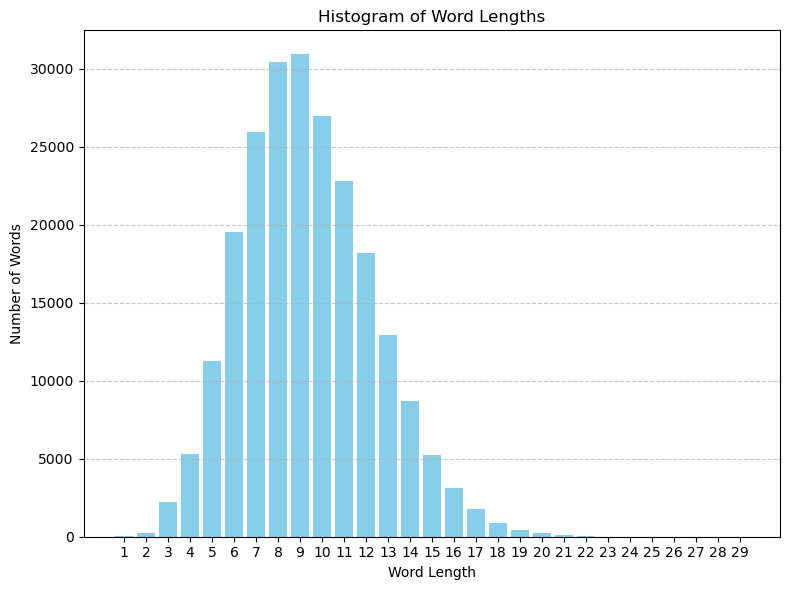

In [141]:
x = list(range(1, len(word_length_count) + 1))
plt.figure(figsize=(8, 6))
plt.bar(x, word_length_count.reshape(-1), color='skyblue')
plt.xlabel("Word Length")
plt.ylabel("Number of Words")
plt.title("Histogram of Word Lengths")
plt.xticks(x)  # Ensure each word length shows up on the x-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

[]

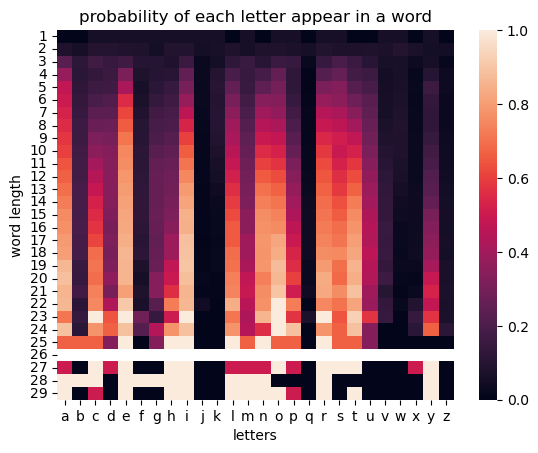

In [142]:
sns.heatmap(distribution, xticklabels=alphabet, yticklabels=range(1, 30))
plt.xlabel('letters')
plt.ylabel('word length')
plt.title('probability of each letter appear in a word')
plt.plot()

In [ ]:
### conditional distribution
max_word_length = 20
letter_to_idx = {letter: idx for idx, letter in enumerate(alphabet)}
# counts: [word_length][given_letter][other_letter]
counts = np.zeros((max_word_length, 26, 26))  # we will zero out the diagonal later
condition_counts = np.zeros((max_word_length, 26))  # how many words of this length contain letter i

for word in word_list:
    word = word.lower().strip()
    n = len(word)
    if not word.isalpha() or n > max_word_length:
        continue

    unique_letters = set(word)
    indices = [letter_to_idx[c] for c in unique_letters]

    for i in indices:
        for j in indices:
            counts[n-1][i][j] += 1
        condition_counts[n-1][i] += 1
    
# Avoid self-counting: remove the diagonal (we want distribution of OTHER letters)
for i in range(max_word_length):
    np.fill_diagonal(counts[i], 0)

# Normalize
cond_dist = np.zeros_like(counts)
for L in range(max_word_length):
    for i in range(26):
        if condition_counts[L][i] > 0:
            cond_dist[L][i] = counts[L][i] / condition_counts[L][i]

[]

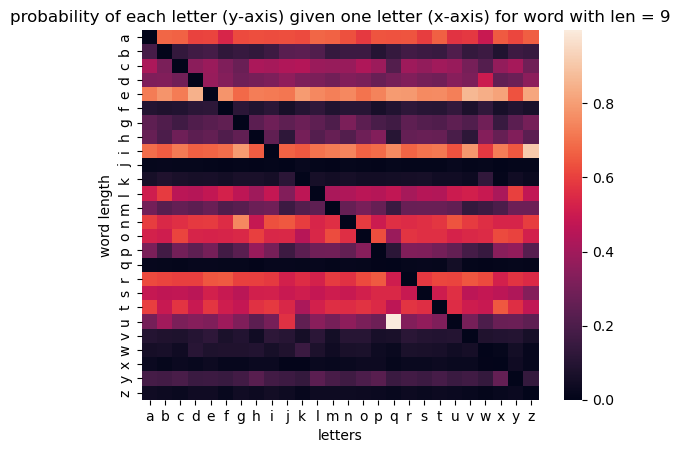

In [144]:
plot_example = np.array(cond_dist[10].T)
sns.heatmap(plot_example, xticklabels=alphabet, yticklabels=alphabet)
plt.xlabel('letters')
plt.ylabel('word length')
plt.title('probability of each letter (y-axis) given one letter (x-axis) for word with len = 9')
plt.plot()

In [145]:
from itertools import combinations

In [146]:
def make_masked_word(word, guessed):
    return ''.join([c if c in guessed else '_' for c in word])

In [147]:
def create_training_examples(word):
    # generate training samples for a given word
    examples = []
    unique_letters = list(set(word))  # preserve order, remove duplicates
    n = len(unique_letters)
    
    for k in range(1,n):
        # k: number of guessed letters
        # get all combinations of k letters
        combinations_list = list(combinations(unique_letters, k))
        if k != 0:
            # up-sample training samples with larger k: number of guessed letters
            # intuition: it is easier to start guessing but it is harder to guess the last one or two letters
            selected_index = np.random.choice([i for i in range(len(combinations_list))], size=k, replace=False)
            selected_list = [combinations_list[i] for i in selected_index]
        else:
            selected_list = combinations_list
        
        for comb in selected_list:
            masked = make_masked_word(word, comb)
            remaining_letters = [c for c in unique_letters if c not in comb]
            guessed = [chr(c) for c in range(ord('a'), ord('a') + 26) if c not in comb and c not in remaining_letters]
            guessed_size = np.random.choice([i for i in range(6)], size = 1)
            guessed = np.random.choice(guessed, size=guessed_size, replace=False)
            guessed = list(guessed) + list(comb)            
            unknown_number = np.sum([list(masked) == '_'])
            if len(guessed) >= 2 and unknown_number/n <= 0.8:
                examples.append({
                    "masked_word": masked,
                    "guessed_letters": ''.join(guessed),
                    "target": ''.join(remaining_letters)  # multiple correct letters
                })
                
    return examples

In [148]:
# compute the proportion of words with given length in the dataset
probabilities = word_length_count.reshape(-1) / np.sum(word_length_count)

In [377]:
max_word_length = 20
all_examples = [[] for _ in range(max_word_length)]
num_examples = [0]*max_word_length

def process_dictionary(word_list, output_file, num_samples = 10000): 
    if num_samples < len(word_list):
        slected_word_list = np.random.choice(word_list, size=num_samples)
    else:
        slected_word_list = word_list
    for word in slected_word_list:
        n = len(word)
        if not word.isalpha() or n > max_word_length:
            # skip word longer than max_word_length
            continue
        word = word.lower().strip()
        examples = create_training_examples(word)
        all_examples[n-1].extend(examples)

    # re-distribute training samples: so that the proportion of 
    # given length of words in trainin data would be equal to that of the whole data
    samples_per_length = np.int32(num_samples * probabilities)
    for i in range(len(all_examples)):
        if len(all_examples[i]) > samples_per_length[i]:
            all_examples[i] = np.random.choice(all_examples[i], size=samples_per_length[i], replace=False)
        num_examples[i] = len(all_examples[i])
        
    # merge all_examples
    merged_list = []
    for sublist in all_examples:
        for item in sublist:
            merged_list.append(item)

    with open(output_file, 'w') as f:
        # write each example as a separate line in the JSONL file
        for ex in merged_list:
            f.write(json.dumps(ex) + "\n")

    print(f"Generated {len(merged_list)} training samples.")

In [378]:
len(word_list)

227300

In [379]:
process_dictionary(word_list, 'light_training_data.jsonl', num_samples=2000000)

Generated 1955995 training samples.


In [380]:
num_examples = np.array(num_examples)

In [381]:
num_examples

array([     0,    215,   5734,  26815,  92317, 171940, 228315, 267945,
       271940, 237157, 200492, 159947, 113999,  76638,  45851,  27655,
        15618,   7558,   3880,   1979])

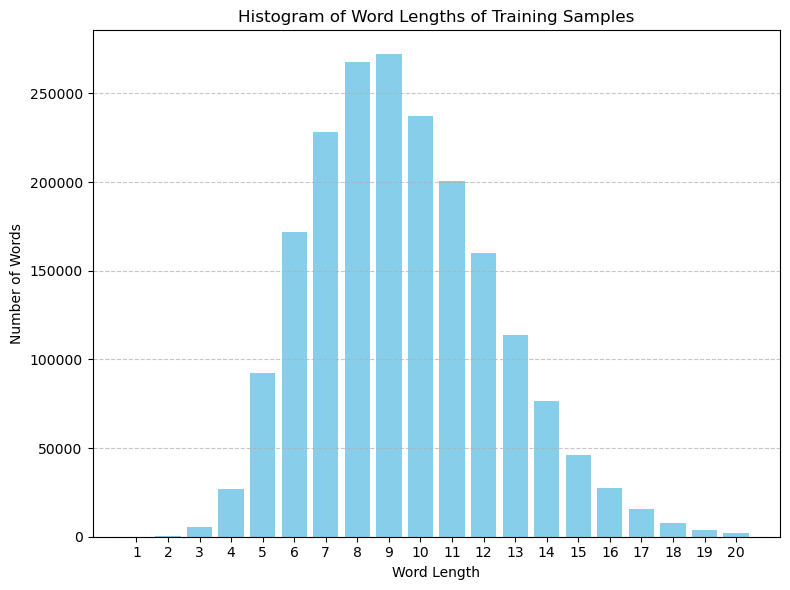

In [382]:
x = list(range(1, max_word_length+1))
plt.figure(figsize=(8, 6))
plt.bar(x, num_examples.reshape(-1), color='skyblue')
plt.xlabel("Word Length")
plt.ylabel("Number of Words")
plt.title("Histogram of Word Lengths of Training Samples")
plt.xticks(x)  # Ensure each word length shows up on the x-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [383]:
input_path = "light_training_data.jsonl"
def read_data(input_path):
    training_data = []
    with open(input_path, "r") as f:
        for line in f:
            item = json.loads(line)
            training_data.append(item)
    return training_data

In [384]:
training_data = read_data(input_path)

In [385]:
random.shuffle(training_data)

In [386]:
training_data

[{'masked_word': '_o___', 'guessed_letters': 'zsao', 'target': 'esj'},
 {'masked_word': '_a__e_____',
  'guessed_letters': 'acgrea',
  'target': 'usthzrl'},
 {'masked_word': '___pto_o__us',
  'guessed_letters': 'njayutsop',
  'target': 'cyr'},
 {'masked_word': 'corsic_', 'guessed_letters': 'ifulticsor', 'target': 'a'},
 {'masked_word': 'sputterin_l_',
  'guessed_letters': 'srxuistenrpl',
  'target': 'gy'},
 {'masked_word': '_unctus', 'guessed_letters': 'vjpructsn', 'target': 'f'},
 {'masked_word': '__pu__z___o_',
  'guessed_letters': 'suozp',
  'target': 'itedna'},
 {'masked_word': '_a_do_ibialis',
  'guessed_letters': 'yemdisbdoal',
  'target': 'uct'},
 {'masked_word': 'c_ntignate', 'guessed_letters': 'ictegna', 'target': 'o'},
 {'masked_word': '___t___c_', 'guessed_letters': 'qct', 'target': 'ieofral'},
 {'masked_word': 'weaken_ng', 'guessed_letters': 'buwegnka', 'target': 'i'},
 {'masked_word': 'a_buta__i_', 'guessed_letters': 'ocuitba', 'target': 'nl'},
 {'masked_word': '_____l_t_e

In [387]:
# build vocabulary ordinal encoding
vocab = ['Pad'] + list(chr(i) for i in range(ord('a'), ord('z')+1)) + ['_']
char2idx = {ch: i for i, ch in enumerate(vocab)}

In [388]:
# encoding functions
def encode_input(masked_word, max_len=20):
    input_str = masked_word
    input_ids = [char2idx[c] for c in input_str]
    if len(input_ids) < max_len:
        input_ids += [char2idx['Pad']] * (max_len - len(input_ids))
    return input_ids

In [389]:
def encode_target(target):
    target_vec = [0] * 26  # only 'a' to 'z'
    for c in target:
        target_vec[ord(c) - ord('a')] = 1
    return target_vec

In [390]:
def encode(masked_word, guessed_letters, target, max_len=20):
    input_ids = encode_input(masked_word, max_len)
    guessed_vec = encode_target(guessed_letters)
    target_vec = encode_target(target)
    return input_ids, guessed_vec, target_vec

In [391]:
def encode_jsonl_data(input_path, output_path, max_len=20):
    encoded_data = []
    with open(input_path, "r") as f:
        for line in f:
            item = json.loads(line)
            masked_word = item["masked_word"]
            guessed_letters = item["guessed_letters"]
            target = item["target"]
            input_ids, guessed_vec, target_vec = encode(
                masked_word, guessed_letters, target, max_len
            )
            encoded_data.append({
                "input_ids": input_ids,
                "guessed_letters": guessed_vec,
                "target_vec": target_vec
            })
    # save encoded data
    with open(output_path, 'w') as f:
        # write each example as a separate line in the JSONL file
        for ex in encoded_data:
            f.write(json.dumps(ex) + "\n")
    
    print(f"Encoded {len(encoded_data)} samples.")
    return encoded_data


In [392]:
output_path = "light_encoded_training_data.jsonl"
training_data = encode_jsonl_data("light_training_data.jsonl", output_path, max_len=20)

Encoded 1955995 samples.


In [393]:
# read data from light_encoded_training_data
input_path = "light_encoded_training_data.jsonl"
training_data = read_data(input_path)

In [394]:
len(training_data)

1955995

In [395]:
training_data_input_ids = []
training_data_guessed_letters = []
training_data_targets = []
for i in range(len(training_data)): 
    training_data_input_ids.append(training_data[i]['input_ids'])
    training_data_guessed_letters.append(training_data[i]['guessed_letters'])
    training_data_targets.append(training_data[i]['target_vec'])

In [396]:
training_data_input_ids = np.array(training_data_input_ids)
training_data_guessed_letters =  np.array(training_data_guessed_letters)
training_data_targets = np.array(training_data_targets)

In [397]:
training_data_length = np.sum(training_data_input_ids != 0, axis=1)/20

In [398]:
print(training_data_input_ids.shape)
print(training_data_guessed_letters.shape)
print(training_data_length.shape)
print(training_data_targets.shape)

(1955995, 20)
(1955995, 26)
(1955995,)
(1955995, 26)


In [399]:
test_size = 0.1

In [400]:
# split training and testing dataset
training_data_input_ids,\
testing_data_input_ids,\
training_data_guessed_letters,\
testing_data_guessed_letters, \
training_data_length,\
testing_data_length,\
training_data_targets, \
testing_data_targets,\
= train_test_split(training_data_input_ids,\
                   training_data_guessed_letters,\
                   training_data_length,\
                   training_data_targets, \
                   test_size=test_size, 
                   shuffle=True,random_state=42)

# Build Model

In [444]:
import os
import datetime
import pandas as pd
from keras.utils import Sequence
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Bidirectional, LayerNormalization, Flatten, GRU, SimpleRNN
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam

In [445]:
# set parameters
vocab_size = 28         # 0 to 27 (0 = Pad)
embedding_dim = 32
sequence_len = 20     # maximum sequence length
binary_vector_len = 26

# Input 1: masked word + guessed letters (sequence input)
seq_input = Input(shape=(sequence_len,), name="seq_input")
embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True)(seq_input)

lstm_output = Bidirectional(LSTM(216, return_sequences=True))(embedding)
#lstm_output = LayerNormalization()(lstm_output)
lstm_output = Bidirectional(LSTM(128, return_sequences=False))(lstm_output)

# Input 2: binary guessed vector of 26
#binary_input = Input(shape=(binary_vector_len,), name="binary_input")
# Input 3: word length
length_input = Input(shape=(1,))
# Concatenate and output
combined = Concatenate()([lstm_output, length_input])

output = Dense(26, activation="sigmoid", name="output")(combined)  # sigmoid for multi-label

# Build model
model = Model(inputs=[seq_input, length_input], outputs=output)

# Create Adam optimizer with a custom learning rate
optimizer = Adam(learning_rate=0.01)

model.compile(optimizer=optimizer, loss="binary_crossentropy")
model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq_input           │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_14        │ (None, 20, 32)    │        896 │ seq_input[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_14        │ (None, 20)        │          0 │ seq_input[0][0]   │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_28    │ (None, 20, 432)   │    430,272 │ embedding_14[0][… │
│ (Bidirectional)     │                   │            │ not_equal_14[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_29    │ (None, 256)       │    574,464 │ bidirectional_28… │
│ (Bidirectional)     │                   │            │ not_equal_14[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 257)       │          0 │ bidirectional_29… │
│ (Concatenate)       │                   │            │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 26)        │      6,708 │ concatenate_12[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,012,340 (3.86 MB)

 Trainable params: 1,012,340 (3.86 MB)

 Non-trainable params: 0 (0.00 B)

In [446]:
# Add EarlyStopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [447]:
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [448]:
class CustomDataGenerator(Sequence):
    def __init__(self, input_data_ids, input_data_length, target_data, batch_size, shuffle=True):
        self.input_data_ids = input_data_ids
        self.input_data_length = input_data_length
        self.target_data = target_data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.input_data_ids))  # Indices to shuffle the data
        self.on_epoch_end()  # Shuffle data at the beginning

    def __len__(self):
        # Returns the number of batches per epoch
        return int(np.floor(len(self.input_data_ids) / self.batch_size))

    def __getitem__(self, index):
        # Generate one batch of data
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_input_ids = [self.input_data_ids[i] for i in batch_indices]
        batch_input_data_length = [self.input_data_length[i] for i in batch_indices]
        batch_target = [self.target_data[i] for i in batch_indices]

        return (np.array(batch_input_ids), np.array(batch_input_data_length)), np.array(batch_target)

    def on_epoch_end(self):
        # Shuffle data at the end of each epoch
        if self.shuffle:
            np.random.shuffle(self.indices)

In [449]:
# Set batch size and training parameters
batch_size = 1024

# Split data into training and validation sets
split_idx = int(0.8 * len(training_data_input_ids))  # 80% for training
train_input_ids = training_data_input_ids[:split_idx]
train_input_data_length = training_data_length[:split_idx]
train_target = training_data_targets[:split_idx]

val_input_ids = training_data_input_ids[split_idx:]
val_input_data_length = training_data_length[split_idx:]
val_target = training_data_targets[split_idx:]


In [450]:
len(train_input_ids)

1408316

In [451]:
# Create the training and validation generators
train_gen = CustomDataGenerator(train_input_ids, train_input_data_length, train_target, batch_size)
val_gen = CustomDataGenerator(val_input_ids, val_input_data_length, val_target, batch_size)

In [ ]:
# Set batch size and training parameters
epochs = 30
# Train the model using the generators
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=[early_stop, tensorboard_callback]
)

/opt/anaconda3/envs/ML_env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 1416s 1s/step - loss: 0.2656 - val_loss: 0.2142
Epoch 2/30
  17/1375 ━━━━━━━━━━━━━━━━━━━━ 26:55 1s/step - loss: 0.2138

In [411]:
model.save("my_model_216_128.keras")

<Axes: >

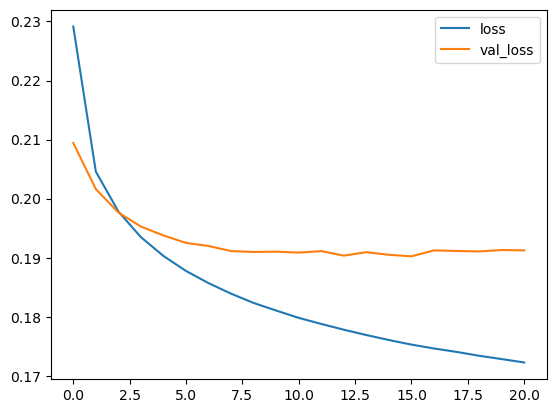

In [412]:
pd.DataFrame(history.history).plot()

In [413]:
testing_data_guessed_letters[0]

array([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0])

In [414]:
testing_data_input_ids[0]

array([27,  1, 13, 16, 27, 15, 14, 27, 27,  5,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0])

In [416]:
# Predict a single sample
prediction = model.predict([
    testing_data_input_ids[0:1],          # shape (1, sequence_len)
    testing_data_guessed_letters[0:1],     # shape (1, 26)
    testing_data_length[0:1]
])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


In [417]:
prediction[0]

array([3.0470815e-07, 7.5522466e-03, 3.0862457e-01, 1.4853124e-01,
       1.7853000e-04, 2.9020878e-03, 6.3662820e-02, 4.8417199e-01,
       9.8276895e-01, 3.1497862e-04, 2.7369907e-02, 2.4298050e-01,
       3.2833144e-05, 1.0567477e-04, 6.4264927e-06, 1.4888909e-06,
       5.6774641e-04, 1.5172568e-01, 1.8825994e-01, 5.0100720e-01,
       1.2660846e-02, 2.6684632e-03, 7.2304676e-03, 8.5039232e-03,
       1.9108335e-02, 4.8081651e-01], dtype=float32)

In [418]:
testing_data_targets[0]

array([0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0])

In [419]:
np.argsort(prediction[0])[::-1]

array([ 8, 19,  7, 25,  2, 11, 18, 17,  3,  6, 10, 24, 20, 23,  1, 22,  5,
       21, 16,  9,  4, 13, 12, 14, 15,  0])

# Make predictions

In [422]:
import numpy as np
import string

def predict_next_letter(model, word, guessed_letters, length):
    """
    Predicts the next letter using the trained model, avoiding already guessed letters.
    """
    # Get model prediction (probabilities for each of the 26 letters)
    probs = model.predict([word, guessed_letters, length], verbose=0)[0]  # shape (26,)
    
    # Convert guessed letters from binary to a boolean mask
    guessed_mask = guessed_letters[0].astype(bool)

    # Set the probabilities of already guessed letters to -1 to ignore them
    probs[guessed_mask] = -1
    
    # Pick the index (letter) with the highest remaining probability
    next_letter_index = np.argmax(probs)
    
    # Convert index back to character
    next_letter = string.ascii_lowercase[next_letter_index]
    
    return next_letter


In [423]:
word = testing_data_input_ids[3:4]
guessed_letters = testing_data_guessed_letters[3:4]
length = testing_data_length[3:4]
predict_next_letter(model, word, guessed_letters, length)

'e'

In [424]:
testing_data_targets[0:1].shape

(1, 26)

# Model testing

In [425]:
k = 1000
test_size = min(k, testing_data_input_ids.shape[0])
prediction = model.predict([
    testing_data_input_ids[:test_size],          
    testing_data_guessed_letters[:test_size],
    testing_data_length[:test_size]
])

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [426]:
top1_preds = np.argmax(prediction, axis=1)

In [427]:
accuracy = np.mean(testing_data_targets[np.arange(len(top1_preds)), top1_preds])

In [428]:
print('the accuracy on testing dataset is:', accuracy)

the accuracy on testing dataset is: 0.716


# API Usage Examples

## To start a new game:
1. Make sure you have implemented your own "guess" method.
2. Use the access_token that we sent you to create your HangmanAPI object. 
3. Start a game by calling "start_game" method.
4. If you wish to test your function without being recorded, set "practice" parameter to 1.
5. Note: You have a rate limit of 20 new games per minute. DO NOT start more than 20 new games within one minute.

In [429]:
from tensorflow.keras.models import load_model

In [438]:
api = HangmanAPI(access_token="a10a70f36b5e444235e2e3527bae82", model=model, distribution = distribution, cond_dist=cond_dist, max_len=20, timeout=2000)

## Playing practice games:
You can use the command below to play up to 100,000 practice games.

In [441]:
api.start_game(practice=1,verbose=True)
[total_practice_runs,total_recorded_runs,total_recorded_successes,total_practice_successes] = api.my_status() # Get my game stats: (# of tries, # of wins)
practice_success_rate = total_practice_successes / total_practice_runs
print('run %d practice games out of an allotted 100,000. practice success rate so far = %.3f' % (total_practice_runs, practice_success_rate))

Successfully start a new game! Game ID: d2f91f42405d. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ _ _ _ _ .
Guessing letter: i
Sever response: {'game_id': 'd2f91f42405d', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ _ _ _ _ _ _ _ '}
Guessing letter: e
Sever response: {'game_id': 'd2f91f42405d', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ e _ e _ _ _ _ _ _ _ e _ _ '}
Guessing letter: a
Sever response: {'game_id': 'd2f91f42405d', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ e _ e _ _ _ _ a _ _ e _ _ '}
Guessing letter: l
Sever response: {'game_id': 'd2f91f42405d', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ e l e _ _ _ _ a _ _ e _ _ '}
Guessing letter: n
Sever response: {'game_id': 'd2f91f42405d', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ e l e n _ _ _ a _ _ e _ _ '}
Guessing letter: o
Sever response: {'game_id': 'd2f91f42405d', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ e l e n o _ _ a _ _ e _ _ '}
Guessing letter: r
Se

In [443]:
result = []
for i in range(100):
    print('Playing ', i, ' th game')
    [_,_,_,total_practice_successes_old] = api.my_status()
    api.start_game(practice=1,verbose=True)
    [_,_,_,total_practice_successes_new] = api.my_status() # Get my game stats: (# of tries, # of wins)
    result.append(total_practice_successes_new - total_practice_successes_old)
    print('updated succesful rate: ', np.mean(result))
    time.sleep(1)

Playing  0  th game
Successfully start a new game! Game ID: 5eb2b030d152. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ .
Guessing letter: e
Sever response: {'game_id': '5eb2b030d152', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ _ _ '}
Guessing letter: i
Sever response: {'game_id': '5eb2b030d152', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ i _ _ _ _ _ _ _ '}
Guessing letter: r
Sever response: {'game_id': '5eb2b030d152', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ i r _ _ _ _ _ _ '}
Guessing letter: t
Sever response: {'game_id': '5eb2b030d152', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ i r _ _ _ _ _ _ '}
Guessing letter: n
Sever response: {'game_id': '5eb2b030d152', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ i r _ _ _ _ _ _ '}
Guessing letter: l
Sever response: {'game_id': '5eb2b030d152', 'status': 'ongoing', 'tries_remains': 2, 'word': '_ i r _ _ _ _ _ _ '}
Guessing letter: a
Sever response: {'game_id': '5eb2b030d152', 'status'

KeyboardInterrupt: 

In [ ]:
np.mean(result)

np.float64(0.54)

## Playing recorded games:
Please finalize your code prior to running the cell below. Once this code executes once successfully your submission will be finalized. Our system will not allow you to rerun any additional games.

Please note that it is expected that after you successfully run this block of code that subsequent runs will result in the error message "Your account has been deactivated".

Once you've run this section of the code your submission is complete. Please send us your source code via email.

In [ ]:
for i in range(1000):
    print('Playing ', i, ' th game')
    # Uncomment the following line to execute your final runs. Do not do this until you are satisfied with your submission
    api.start_game(practice=0,verbose=True)
    [total_practice_runs,total_recorded_runs,total_recorded_successes,total_practice_successes] = api.my_status() # Get my game stats: (# of tries, # of wins)
    recorded_success_rate = total_recorded_successes / total_recorded_runs
    print('run %d recorded games out of an allotted 1000. recored success rate so far = %.3f' % (total_recorded_runs, recorded_success_rate))
    # DO NOT REMOVE as otherwise the server may lock you out for too high frequency of requests
    time.sleep(0.5)

Playing  0  th game
Successfully start a new game! Game ID: 3c63113cff52. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ .
Guessing letter: e
Sever response: {'game_id': '3c63113cff52', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ _ _ _ _ e '}
Guessing letter: i
Sever response: {'game_id': '3c63113cff52', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ _ _ e '}
Guessing letter: a
Sever response: {'game_id': '3c63113cff52', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ _ _ _ _ _ _ _ e '}
Guessing letter: o
Sever response: {'game_id': '3c63113cff52', 'status': 'ongoing', 'tries_remains': 4, 'word': 'o _ _ _ o _ _ _ _ e '}
Guessing letter: t
Sever response: {'game_id': '3c63113cff52', 'status': 'ongoing', 'tries_remains': 4, 'word': 'o _ _ _ o _ _ _ t e '}
Guessing letter: r
Sever response: {'game_id': '3c63113cff52', 'status': 'ongoing', 'tries_remains': 4, 'word': 'o _ _ r o _ _ _ t e '}
Guessing letter: h
Sever response: {'game_id': '3c63113cf

HangmanAPIError: {'error': 'You have reached 1000 of games', 'status': 'denied'}

## To check your game statistics
1. Simply use "my_status" method.
2. Returns your total number of games, and number of wins.

In [ ]:
[total_practice_runs,total_recorded_runs,total_recorded_successes,total_practice_successes] = api.my_status() # Get my game stats: (# of tries, # of wins)
success_rate = total_recorded_successes/total_recorded_runs
print('overall success rate = %.3f' % success_rate)

overall success rate = 0.501


# Stragety

My main strategy is to train an LSTM RNN model to learn the conditional probability of the next likely letter, given the masked word (with underscores) and the set of previously guessed letters. The model will then output the letter with the highest probability that has not yet been guessed.

To train the model effectively, each training sample will contain at least two known letters, and less than 80% of the word will be masked. The rationale behind this is to ensure that the model learns meaningful dependencies; when no letters are known, there is no context for the model to leverage, and the best stragety is to guess the word with highest probability given the word length.

As a result, the first guess will be based on the most probable letter given only the word length, where the probability is calculated using training samples. The second guess will be based on the highest probability conditioned on both the word length and the first revealed letter. After that, the model will handle the remaining letter predictions using the full context of the current word state and guessed letters.